In [607]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':120})

import sys
sys.path.append("/home/msdos/um_scripts/desiarc-main/arc")
import find_center as fc
import sys
sys.path.append("/home/msdos/um_scripts/")
import find_center as fc
from spotfinder import spotfinder

plt.rcParams.update({'figure.dpi':120})


In [64]:
def angle_between(c, p1, p2):
    # p1, p2 are points; c is center
    a = np.array(p1)
    b = np.array(c)
    c = np.array(p2)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)


def find_spot(fitsname, fitspath,  
              expected_spot_count=1, 
              regionsname='../regions.reg', 
              verbose=False):
    """
    spotfinder handler
    input:
        fitsname:
        fitspath (str): relative or full path to the folder
        regionsname (str):
        verbose (bool):
    output: 
        centroids (dict): raw output from spotfinder

    """
    import os
    
    assert isinstance(fitsname, str)

    _ifn = f"{fitspath}/{fitsname}"
    if not (os.path.isfile(_ifn)):
        print(f"File not found \n{_ifn}")
#     if expected_spot_count != 1:
#         raise NotImplementedError("This mode wasn't tested here")
    try: 
        sf=spotfinder.SpotFinder(_ifn, expected_spot_count)
        centroids = sf.get_centroids(print_summary = verbose, 
                                     region_file=regionsname)
        if verbose: print(centroids)
    
    except Exception as err: #ignore photo if an error is raised
        print(f"{err}\nWarning: spot not found ")
        inval_number = np.nan
        return {  'peaks': [inval_number], 
                      'x': [inval_number], 
                      'y': [inval_number], 
                   'fwhm': [inval_number], 
                 'energy': [inval_number]} 
    return centroids


def collect_xy(files, picspath):
    # treating for single file
    if isinstance(files, str):
        files = [files]
    x2, y2 = [],[]
    for fullname in files:
        iname = fullname.split('/')[-1]
        _c = find_spot(iname, picspath)
        x2.append(_c['x'])
        y2.append(_c['y'])
    return x2, y2

# Fiducial calibration

TURN ON FIDUCIAL, TURN OFF POSITIONER BACKLIGHT

In [3]:
from astropy.io import fits 
fiducial_pic = "20230217-162739.fits"
fiducial_path = '/home/msdos/um_scripts/sbigpics/getpic-20230217-162737'
dd = find_spot(fiducial_pic, 
               fiducial_path, 
               regionsname=False, 
               expected_spot_count=4)

Edge hot spot
Edge hot spot
peak = 82780.01526188022 brightness appears out of expected range
peak = 83552.06737042287 brightness appears out of expected range
peak = 74737.42432520037 brightness appears out of expected range
peak = 70380.10144509711 brightness appears out of expected range


(1000.0, 1200.0)

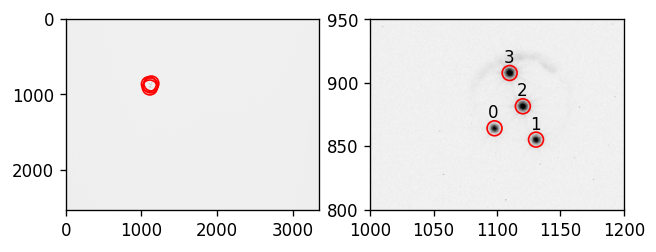

In [4]:
img = fits.getdata(f"{fiducial_path}/{fiducial_pic}")

plt.subplot(121)
plt.imshow(np.log(img), cmap='gray_r', origin='lower')
plt.scatter(dd['x'], dd['y'],  s=80, facecolors='none', edgecolors='r')
plt.gca().invert_yaxis()
plt.subplot(122)
plt.gca().invert_yaxis()
plt.imshow(np.log(img), cmap='gray_r', origin='lower')
plt.scatter(dd['x'], dd['y'],  s=80, facecolors='none', edgecolors='r')
for pt, (i,j) in enumerate(zip(dd['x'], dd['y'])):
    plt.annotate(pt, xy=(i-5,j+8), xycoords='data')
plt.ylim([800, 950])
plt.xlim(1000, 1200)

In [5]:
cx = np.array(dd['x'])
cy = np.array(dd['y'])
d = lambda i, j: np.hypot(cx[j] -cx[i], cy[j] - cy[i])

# User should MATCH ORDER OF SPOTS
dphys = { (3,2):1,(3,1):2, (3,0):1.6, (2,1):1, (2,0):1,  (1,0):1.2  }
ratioall = np.array([])
dph =  np.array([1, 2, 1.6, 1, 1, 1.2]) # weighting by the distance
pix2mm = np.array([])
for i,j in [(3,2), (3,1), (3,0), (2,1), (2,0), (1,0)]:
    _x = d(i,j)/dphys[(i,j)]
    ratioall = np.append(ratioall, _x)
    pix2mm = np.append(pix2mm, dphys[(i,j)]/d(i,j))
# assert pix2mm
    
print(f"{ratioall.mean():.4f} +/- {np.std(ratioall, ddof=1):.4f}")
mu_mm2pix = (ratioall*dph).sum() /dph.sum()
std_mm2pix = np.sqrt( np.sum(dph* (ratioall-mu_mm2pix)**2)/ ( dph.sum() * (len(dph)-1)/len(dph) ) )

def stats(pix2mm, w):
    # w: dph Physical distance in the model
    N = len(w!=0)
    _mu = np.sum(pix2mm * w)/w.sum()
    _std = np.sum(w * (pix2mm - _mu)**2)/( w.sum() * ((N-1)/N) )
    _std = np.sqrt(_std)
    return _mu, _std

# ------------
# Calibration 
# weighting values based on the (expected) distance size from template
mu1, std1 = stats(pix2mm, dph)
mu2, std2 = stats(pix2mm, np.ones_like(pix2mm))
    
print(f"weighted: {mu_mm2pix:.4f} +/- {std_mm2pix:.4f}" )
print(f"weighted: {mu1:.6f} +/- {std1:.6f}" )
ratioall, (ratioall*dph).sum() /dph.sum(),  #mu2, std2, 1/mu2

28.2450 +/- 0.0165
weighted: 28.2439 +/- 0.0148
weighted: 0.035406 +/- 0.000019


(array([28.23889579, 28.23819404, 28.24605968, 28.23753624, 28.27744879,
        28.23202334]),
 28.24389646164703)

In [65]:
pix2mm =  0.035406 # +/- 0.000019

# Positional Calibration

TURN OFF FIDUCIAL, TURN ON POSITIONER BACKLIGHT

In [612]:
def get_timecol(db):
    new = db.label.str.split("-", n=1, expand=True)
    new.columns = ['label', 'session']
    db['label'] = new['label']
    db.insert(1, "session", new['session'])
    db['session'] = pd.to_datetime(db['session'], format= '%Y%m%d-%H%M%S' )#.dt.time
    return 

def query_time(db, date=None, datemin=None, datemax=None):
    """
    First run get_timecol(database)
    datemin, datemax (str): e.g "2023-02-03 13:36:00"
    """
   
    if date is not None:
        return db['session'] == np.datetime64(date)
 
    dmin = [np.datetime64(datemin) if not None else None][0]
    dmax = [np.datetime64(datemax) if not None else None][0]
     
    cond1 = db["session"] >= dmin
    cond2 = db["session"] <= dmax
    if (datemin is not None) & (datemax is not None):
        return cond1 & cond2
    elif datemin is None:
        return cond2
    elif datemax is None: 
        return cond1 
    else:
        print("check datemin datemax fields")

def setplot(xc=0, yc=0, rmax=6.0, grid=True):
    plt.xlim(xc-rmax+.3, xc+rmax+.3)
    plt.ylim(yc+ rmax+.3,yc-rmax+.3)
    plt.plot(xc, yc, 'r+')
    plt.gca().set_aspect('equal')
    if grid:
        plt.grid(linestyle='--',linewidth=0.5)

def plot_circle(xc, yc, R, kwargs={}):
    _th = np.linspace(0, 2*np.pi)
    plt.plot(R* np.cos(_th)+xc, R*np.sin(_th)+yc, c='g', ls='--', lw=0.6)
    return 

In [770]:
db = pd.read_csv("../output/database.csv")
get_timecol(db)
db.tail()


,label,session,mtang1,mtang2,move,posid,direction,speed,motor,angle,xpix,ypix,xytgt,peaks,fwhm
4,smallarcphi15,2023-03-15 14:55:18,0.0,0.0,20230315-145600,4852,cw,cruise,phi,15.0,1949.463189,982.825501,0,78702.9342,3.6800
5,smallarcphi15,2023-03-15 14:55:18,0.0,0.0,20230315-145611,4852,ccw,cruise,phi,15.0,1968.187946,964.086730,0,78012.3901,3.4841
6,smallarcphi15,2023-03-15 14:55:18,0.0,0.0,20230315-145622,4852,ccw,cruise,phi,15.0,1981.040432,938.496442,0,72334.9045,3.3609
7,smallarcphi15,2023-03-15 14:55:18,0.0,0.0,20230315-145633,4852,ccw,cruise,phi,15.0,1984.799705,910.241402,0,73146.4151,3.3318
8,smallarcphi15,2023-03-15 14:55:18,0.0,0.0,20230315-145643,4852,ccw,cruise,phi,15.0,1979.109661,882.107751,0,74082.6522,3.3288


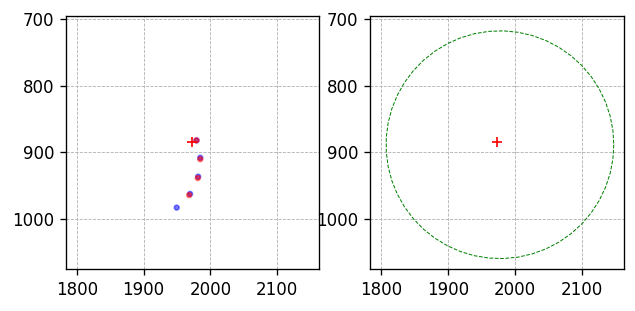

In [771]:

m2 = query_time(db, datemin='2023-03-09 18:30:00')
m2 = (m2) & ( db['label'].str.contains('arcph') )
color2 = ['b' if i =='cw' else 'r' for i in db['direction'][m2]]
plt.subplot(121)
plt.scatter('xpix', 'ypix', data=db[m2], c=color2, s=8, alpha=0.5)
setplot(1973, 885, 190)

plt.subplot(122)

m1 = query_time(db, datemin='2023-03-09 18:30:00')
m1 = (m1) & ( db['label'].str.contains('arcth') ) & (db['motor']=='theta')
color1 = ['b' if i =='cw' else 'r' for i in db['direction'][m1]]

plt.scatter('xpix', 'ypix', data=db[m1], c=color1, s=8, zorder=10)
plot_circle(xc/pix2mm, yc/pix2mm, (R1+R2)/pix2mm)
setplot(1973, 885, 190)


In [615]:
# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)]
print(xc1, yc1, Rarc1)


xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])]
print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1 (mm): {R1:.4} \nR2 (mm): {R2:.4}")
print(f"xc, yc (mm): [{xc:.5f}, {yc:.5f}]")
print(f"pix2mm {pix2mm}")
print(f"pixcenter [{xc/pix2mm:.5f}, {yc/pix2mm:.5f}]")

70.02267127828885 31.461353771491684 6.047888714559511
67.11350897220677 32.01973710830175 3.079173997030469
R1 (mm): 2.962 
R2 (mm): 3.079
xc, yc (mm): [70.02267, 31.46135]
pix2mm 0.035406
pixcenter [1977.70636, 888.58820]


In [616]:
db['xmm'] = db["xpix"].values * pix2mm #-xc
db['ymm'] = db["ypix"].values * pix2mm #-yc

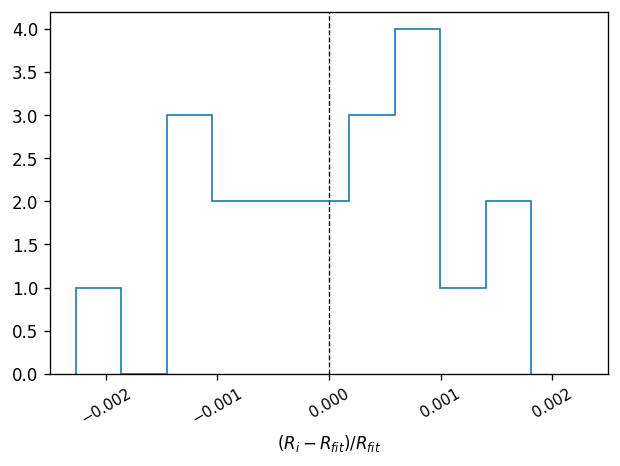

In [682]:
# msk_arcth1 =( db['label'].str.contains('arcth30') )| (db['direction']=='cw') & (query_time(db, "2023-02-07"))
DR = np.hypot(db['xmm'][m1] - xc, db['ymm'][m1] - yc)
DRcw = np.hypot(db['xmm'][m1 & (db.direction=='cw')] - xc, db['ymm'][m1& (db.direction=='cw')] - yc)
DRccw = np.hypot(db['xmm'][m1 & (db.direction=='ccw')] - xc, db['ymm'][m1& (db.direction=='ccw')] - yc)

plt.hist(DR - Rarc1 , histtype='step', density=False)
# plt.hist(DRcw- Rarc1, histtype='step', density=True)
# plt.hist(DRccw -Rarc1, histtype='step', density=True)


plt.xlabel("$ (R_i - R_{fit})/ R_{fit}$")
plt.xticks(fontsize=9, rotation =30); 
plt.xlim(-0.0025, 0.0025)
plt.axvline(0, c='k',lw=0.8, zorder=0, ls='--')

In [618]:
askedangle = db[m2]['angle'].values * np.array( [1 if i =='ccw' else -1 for i in  db[m2]['direction']])

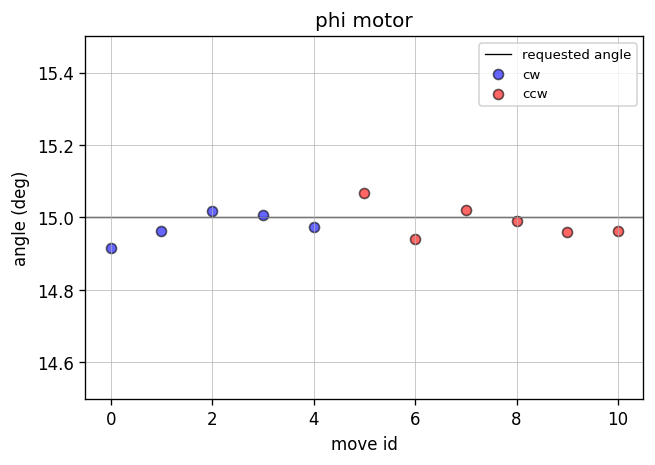

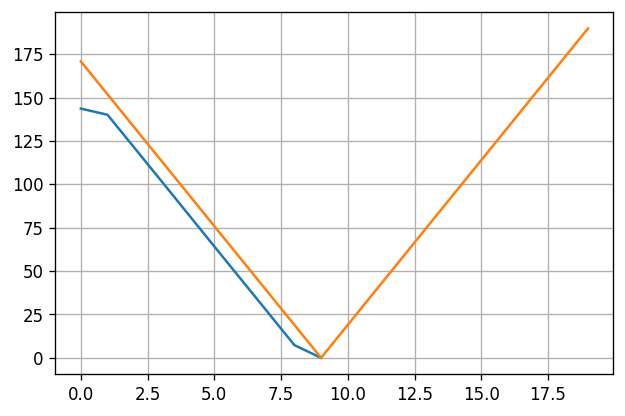

In [640]:
# #CW
# dang=[]
# correction = -2*1.995
# kwplot = dict(marker='o', edgecolors='k', alpha=0.6)
# msk = (m2) & (db['direction'] == 'cw')
# c = ['b' if i == 'cw' else 'r' for i in db[msk]['direction']]

# for i, j in zip(db['xmm'][msk].values, db['ymm'][msk].values):
#     dang.append(angle_between((xc2,yc2), (-6,0), (i, j)))
    
# dang = np.array(dang)[0:]
# displ = dang[1:]-dang[:-1] 
# plt.scatter(range(len(dang)-1), -displ + 0*correction, c='b', #c[1:], 
#          label='', **kwplot)

# plt.scatter(range(len(dang)-1), askedangle[1:] + -correction*np.sign(askedangle[1:]), marker='x', 
#          alpha=0.6)

# CCW
dang=[]
msk = (m2) & (db['direction'] == 'cw')
for i, j in zip(db['xmm'][msk].values, db['ymm'][msk].values):
    dang.append(angle_between((xc2,yc2), (6,0), (i, j)))
dang = -np.array(dang)[2:-3]

plt.scatter(range(len(dang)-1), dang[1:]-dang[:-1] + correction, c='b', 
            label='cw', **kwplot)


# CCW
dang=[]
msk = (m2) & (db['direction'] == 'ccw')
for i, j in zip(db['xmm'][msk].values, db['ymm'][msk].values):
    dang.append(angle_between((xc2,yc2), (6,0), (i, j)))
dang = np.array(dang)[:-3]

plt.scatter(range(5,len(dang)-1 +5), dang[1:]-dang[:-1] + correction, c='r', 
            label='ccw', **kwplot)


plt.ylim(14.5, 15.5)
plt.xlabel("move id")
plt.ylabel("angle (deg)")
plt.grid('--', lw=.4)
plt.title("phi motor")

plt.axhline(15, c='k', zorder=0, lw=.8, label='requested angle')
plt.legend(loc='best', fontsize=8)

plt.show()
plt.plot(np.cumsum(displ) -1*np.cumsum(displ).min())
csumasked = np.cumsum(askedangle[1:] -correction*np.sign(askedangle[1:])) 
plt.plot(csumasked - csumasked.min()  )
plt.grid()

In [310]:
db[m2]

,label,session,mount,move,posid,direction,speed,motor,angle,xpix,ypix,peaks,fwhm,xmm,ymm
766,arcphi15,2023-03-07 20:37:57,0,20230307-203800,4852,cw,cruise,phi,0.0,1981.526084,890.678284,73179.5794,3.3173,70.157913,31.535355
767,arcphi15,2023-03-07 20:37:57,0,20230307-203810,4852,cw,cruise,phi,15.0,1984.333842,916.964060,72927.0626,3.3216,70.257324,32.466030
768,arcphi15,2023-03-07 20:37:57,0,20230307-203819,4852,cw,cruise,phi,15.0,1978.267792,944.889003,73143.9051,3.3351,70.042549,33.454740
769,arcphi15,2023-03-07 20:37:57,0,20230307-203828,4852,cw,cruise,phi,15.0,1963.433495,969.290366,74164.2869,3.3763,69.517326,34.318695
770,arcphi15,2023-03-07 20:37:57,0,20230307-203836,4852,cw,cruise,phi,15.0,1941.346831,987.608802,73172.3619,3.3470,68.735326,34.967277
771,arcphi15,2023-03-07 20:37:57,0,20230307-203846,4852,cw,cruise,phi,15.0,1914.508401,997.714854,73545.7993,3.3788,67.785084,35.325092
772,arcphi15,2023-03-07 20:37:57,0,20230307-203854,4852,cw,cruise,phi,15.0,1885.940765,998.601882,74789.7603,3.4535,66.773619,35.356498
773,arcphi15,2023-03-07 20:37:57,0,20230307-203904,4852,cw,cruise,phi,15.0,1858.461704,990.095180,76180.4494,3.4795,65.800695,35.055310
774,arcphi15,2023-03-07 20:37:57,0,20230307-203914,4852,cw,cruise,phi,15.0,1835.327674,973.185914,79332.6773,3.8104,64.981612,34.456620
775,arcphi15,2023-03-07 20:37:57,0,20230307-203924,4852,cw,cruise,phi,15.0,1818.940574,949.669396,76725.2023,3.5515,64.401410,33.623995


# xy test

In [767]:
db = pd.read_csv("../output/database.csv") #l27 -> l28
db

,label,mtang1,mtang2,move,posid,direction,speed,motor,angle,xpix,ypix,xytgt,peaks,fwhm
0,smallarcphi15-20230315-145518,0.0,0.0,20230315-145520,4852,cw,cruise,phi,0.0,1979.119916,882.120526,0,73818.8434,3.3263
1,smallarcphi15-20230315-145518,0.0,0.0,20230315-145530,4852,cw,cruise,phi,15.0,1984.710102,908.088044,0,72893.1379,3.3442
2,smallarcphi15-20230315-145518,0.0,0.0,20230315-145540,4852,cw,cruise,phi,15.0,1981.626135,936.439198,0,73184.8460,3.3288
3,smallarcphi15-20230315-145518,0.0,0.0,20230315-145550,4852,cw,cruise,phi,15.0,1969.480227,962.274630,0,73634.4156,3.3500
4,smallarcphi15-20230315-145518,0.0,0.0,20230315-145600,4852,cw,cruise,phi,15.0,1949.463189,982.825501,0,78702.9342,3.6800


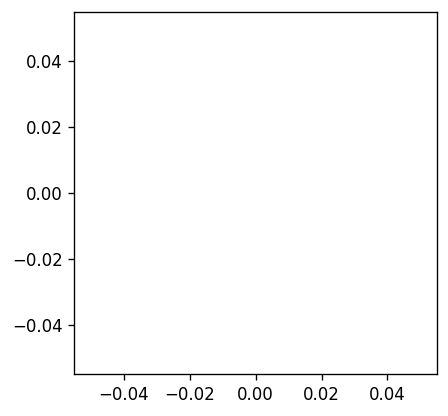

In [769]:
db = pd.read_csv("../output/database.csv") #l27 -> l28
get_timecol(db)
plt.scatter('xpos', 'ypos', data=get_lastdbxy(60), marker='x')
plt.scatter('xpos', 'ypos', data = xytgt, marker='.')
plt.gca().set_aspect('equal')
# plt.pause(1)
# plt.show()

In [565]:
db['session'][db["label"].str.contains('xy60')].unique()

array(['2023-02-17T11:51:43.000000000', '2023-02-17T19:24:56.000000000',
       '2023-03-07T19:11:20.000000000', '2023-03-07T20:43:06.000000000',
       '2023-03-09T18:04:21.000000000', '2023-03-09T18:07:31.000000000',
       '2023-03-09T20:02:34.000000000', '2023-03-09T20:04:03.000000000',
       '2023-03-09T20:21:47.000000000', '2023-03-09T21:14:02.000000000',
       '2023-03-10T10:21:45.000000000', '2023-03-10T10:41:27.000000000',
       '2023-03-10T10:58:24.000000000', '2023-03-10T11:13:52.000000000'],
      dtype='datetime64[ns]')

['2023-03-10T10:21:45.000000000']
(60, 2)


/home/msdos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


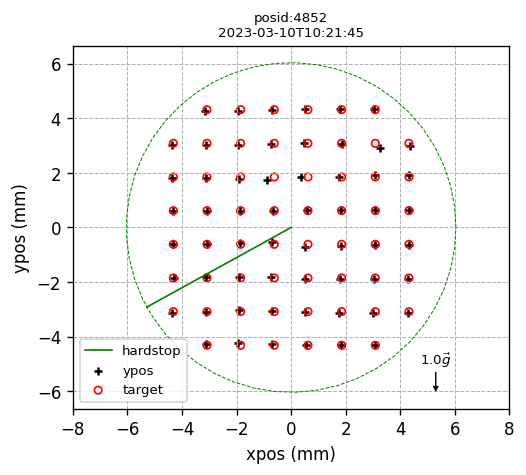

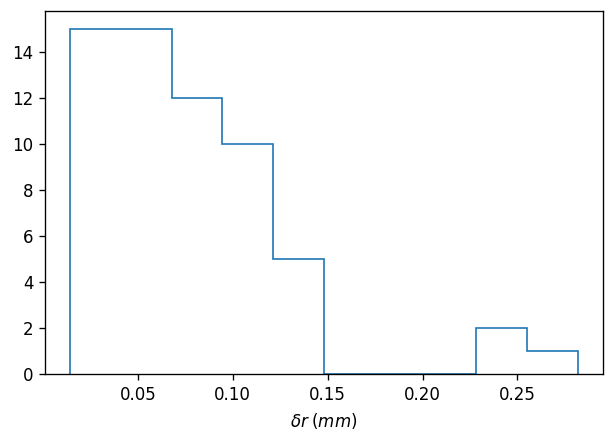

In [666]:
dt1, dt2 = '2023-03-09 18:05:35', '2023-03-09 19:01:38'
dt1, dt2 = '2023-03-09 19:05:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 19:45:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 20:02:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 20:20:35', '2023-03-09 21:01:38'
dt1, dt2 = '2023-03-09 21:10:35', '2023-03-09 21:30:38'
dt1, dt2 = '2023-03-10 10:20:00', '2023-03-10 10:22:00' # backlash = 1.8 best case so far
# dt1, dt2 = '2023-03-10 10:40:00', '2023-03-10 10:42:00' # backlash = 2.0
#dt1, dt2 = '2023-03-10 10:58:00', '2023-03-10 10:59:00' # backlash = 1.9
# dt1, dt2 = '2023-03-10 11:13:00', '2023-03-10 11:14:00' # backlash = 1.8 + sleep 01 s

def get_lastdbxy(tail, label='xy60'):
    mxy = db["label"].str.contains(label)
#     mxy = (mxy) & (query_time(db, datemin=datemin, datemax=datemax))
    dbxy = db[['xpix','ypix']][mxy].tail(tail).reindex()
    dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xc
    dbxy['ypos'] = dbxy["ypix"].values * pix2mm -yc
    dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)
    return dbxy

def get_dbxy(db,  datemin, datemax, label='xy60'):
    mxy = db["label"].str.contains(label)
    mxy = (mxy) & (query_time(db, datemin=datemin, datemax=datemax))
    print(db.session[mxy].unique())
    dbxy = db[['xpix','ypix']][mxy].reindex()
    print(dbxy.shape)
    dbxy['xpos'] = dbxy["xpix"].values * pix2mm -xc
    dbxy['ypos'] = dbxy["ypix"].values * pix2mm -yc
    dbxy.set_index(np.arange(dbxy.shape[0]), inplace=True)
    return dbxy

def plot_xy(label, datemin, datemax, movefn="XY_60b.txt", title='', show=True ):
    dbxy = get_dbxy(db, datemin, datemax,label='xy60')
    xytgt = pd.read_csv(f"../movetables/{movefn}", sep=" ", header=None)
    xytgt.columns = ['xpos', 'ypos']

    plt.scatter('xpos', 'ypos', data=dbxy, c='k', marker ='+', s=20)#c=dbxy.index,cmap='Blues', edgecolors='b')
    # # plt.colorbar()
    plt.scatter('xpos', 'ypos', data=xytgt, edgecolors='r', s=20, c='', lw=1,label='target')
    plt.xlabel('xpos (mm)')
    plt.ylabel('ypos (mm)')
    plt.title(title, fontsize=8)
    plt.xlim(-8,8)
    plt.gca().set_aspect('equal')
    plt.legend(loc='lower left', fontsize=8)
    if show:
        plt.show()
    return dbxy, xytgt
    # plt.legend(loc='best', fontsize=7)
    
def plot_xyhist(label, datemin, datemax, dbxy=None, joinplot=False, plotall=False):
    if dbxy is None:
        dbxy = get_dbxy(db, datemin, datemax)
    dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
    rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
    dr = np.hypot(dx, dy)
    if plotall:
        plt.plot(dx, '.-', label='dx (mm)', alpha=0.5)
        plt.plot(dy, '.-', label='dy (mm)', alpha=0.5)
        plt.plot(dr, 'k.-', label='dr (mm)', zorder=0)
        plt.legend(loc='best', fontsize=9)
        plt.show()
    plt.hist(np.hypot(dx,dy), histtype='step')
    plt.xlabel('$\delta r \;(mm)$')
    if not joinplot:
        plt.show()
    return dr
    
plot_circle(0,0, 6.04)
plt.plot(np.linspace(0, 6.04* np.cos(-166)), np.linspace(0, 6.04* np.sin(-166)), lw=1 , c='g', label='hardstop'  )
plt.grid(lw=0.6, ls='--')   
plt.annotate('$1.0\\vec{g}$', xy=(5.3, -6), xycoords='data',
             xytext=(5.3, -5), textcoords='data',
             horizontalalignment='center',
             fontsize=8,
             arrowprops=dict(color='k', lw=.4, width=.4, headwidth=3.0,
                             headlength=3.0, ls='-')
           )
dbxy, xytgt = plot_xy(label, dt1, dt2, title='posid:4852\n2023-03-10T10:21:45' )

rdiff = plot_xyhist(label, dt1, dt2, dbxy=dbxy)



In [669]:
dados = [rdiff.min(), rdiff.max(), np.median(rdiff), np.sqrt(np.mean(rdiff**2))]
nomes = ["min", "max", "median", "rms"]
for i, j in zip(nomes, dados): 
    print(f"{i:6}: {j*1000:<3.4f} um")

min   : 14.3739 um
max   : 281.6498 um
median: 67.6162 um
rms   : 93.8006 um


In [670]:
rmsk = rdiff<0.2

dados = [rdiff[rmsk].min(), rdiff[rmsk].max(), np.median(rdiff[rmsk]), np.sqrt(np.mean(rdiff[rmsk]**2))]
nomes = ["min", "max", "median", "rms"]
for i, j in zip(nomes, dados): 
    print(f"{i:6}: {j*1000:<3.4f} um")

min   : 14.3739 um
max   : 147.8069 um
median: 64.9884 um
rms   : 76.5593 um


In [450]:
3*np.radians(1)

0.05235987755982989

In [195]:
np.degrees(np.arctan( (5.789/1.743)**-1))

16.756431973194914

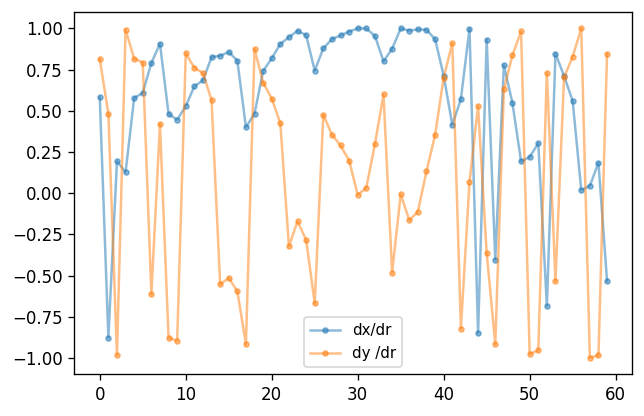

In [523]:
dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
plt.plot(dx/dr, '.-', label='dx/dr', alpha=0.5)
plt.plot(dy/dr, '.-', label='dy /dr', alpha=0.5)
# plt.plot(dr, 'k.-', label='dr (mm)', zorder=0)
plt.legend(loc='best', fontsize=9)
plt.show()


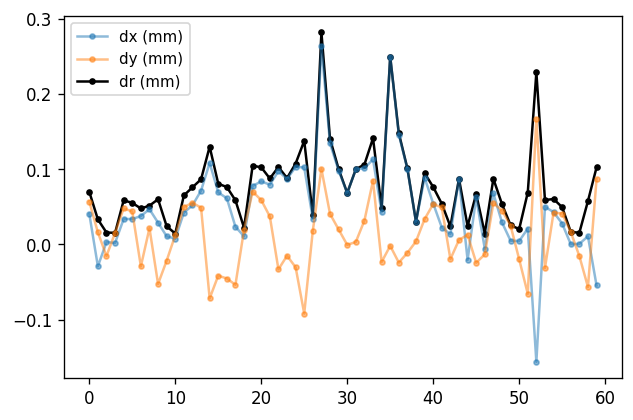

Text(0.5, 0, '$\\delta r \\;(mm)$')

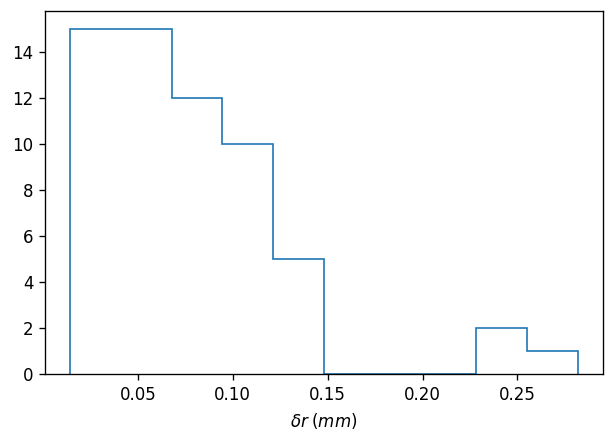

In [520]:
dx, dy = xytgt.subtract(dbxy[['xpos', 'ypos']].values, ).values.T
rpos = np.hypot(dbxy['xpos'].values, dbxy['ypos'].values)
dr = np.hypot(dx, dy)
plt.plot(dx, '.-', label='dx (mm)', alpha=0.5)
plt.plot(dy, '.-', label='dy (mm)', alpha=0.5)
plt.plot(dr, 'k.-', label='dr (mm)', zorder=0)
plt.legend(loc='best', fontsize=9)
plt.show()
plt.hist(np.hypot(dx,dy), histtype='step')
plt.xlabel('$\delta r \;(mm)$')

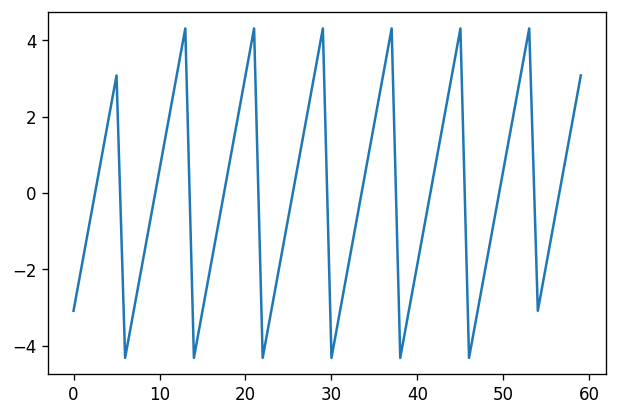

In [349]:
plt.plot(yt)

Max arrow length = 259.1 um


63.290209156398866

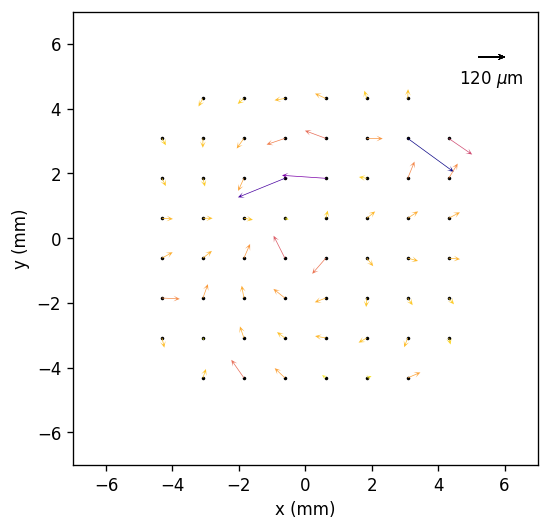

In [757]:
# Creating plot
fig, ax = plt.subplots(figsize = (5, 5))

label = 'xy60'
xpos = dbxy['xpos'].values
ypos = dbxy['ypos'].values
xt = xytgt['xpos'].values
yt = xytgt['ypos'].values

# Calculate residuals in microns.
u = 1e3 * (xpos - xt + 0.0514)
v = 1e3 * (ypos - yt +  0.01185)
dr = np.hypot(u, v)
print(f'Max arrow length = {np.max(dr):.1f} um')

ref=120
ax.scatter(xt, yt, marker='.', c='k', s=5)
Q = ax.quiver(xt, yt, u, v, dr, angles='xy', scale=150, scale_units='xy',
              headwidth=8, headlength=9, width=0.001*1.5, color='k' ,cmap='plasma_r')

ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref} $\mu$m', labelpos='S')
ax.set_xlim(-7,7)
ax.set_ylim(-7,7)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')

np.mean(dr)

In [787]:
def func(xoff, yoff):
    u = 1e3 * (xpos - xt + xoff)
    v = 1e3 * (ypos - yt + yoff)
    return np.sqrt(np.mean(np.hypot(u, v)**2))



xx,yy = np.random.rand(30000)*2*0.1 -0.1, np.random.rand(30000)*2*0.1 - 0.1

vals = np.array([func(ii,  jj) for (ii, jj) in zip(xx,yy)])
amin = np.argmin(vals)
vals.shape, vals[amin], xx[amin], yy[amin]

((30000,), 77.3155807900255, 0.05207625353863218, 0.011474224900408947)

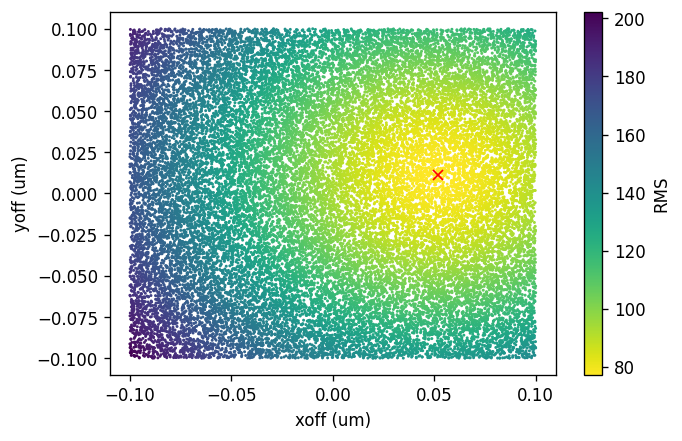

In [788]:
plt.scatter(xx,yy, c=vals, cmap='viridis_r', s=.6 )
plt.plot(xx[amin], yy[amin], 'rx')
plt.xlabel("xoff (um)")
plt.ylabel("yoff (um)")
plt.colorbar(label='RMS')

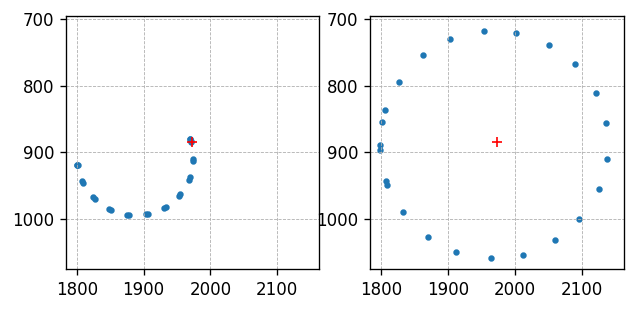

In [251]:
m2 = query_time(db, datemin='2023-02-17', datemax='2023-02-18')
m2 = (m2) & ( db['label'].str.contains('arcph') )
plt.subplot(121)
plt.scatter('xpix', 'ypix', data=db[m2], s=8)
setplot(1973, 885, 190)

plt.subplot(122)

m1 = query_time(db, datemin='2023-02-17', datemax='2023-02-18')
m1 = (m1) & ( db['label'].str.contains('arcth') ) & (db['motor']=='theta')

plt.scatter('xpix', 'ypix', data=db[m1], s=8)
setplot(1973, 885, 190)


In [252]:
# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)]
print(xc1, yc1, Rarc1)

xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])]
print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1: {R1:.4}, R2: {R2:.4} mm")
print(f"xc, yc: {xc}, {yc} mm")
print(f"pix2mm {pix2mm}")
xc/pix2mm, yc/pix2mm

69.70240066686817 31.441310814856173 6.040776547566441
66.81557596996126 32.124330022730454 3.0790803167305896
R1: 2.967, R2: 3.079 mm
xc, yc: 69.70240066686817, 31.441310814856173 mm
pix2mm 0.035406


(1968.6606978158552, 888.022109666615)

In [508]:
6*np.sin(np.radians(2)), np.radians(2)

(0.2093969802150058, 0.03490658503988659)

# UPDATE THE CODE WITH THE VALUES ABOVE

In [52]:
# xc, yc, Rarc = fc.get_circle(db[msk_arcth])
xc1, yc1, Rarc1 = [i*pix2mm for i in fc.get_circle(db[m1],)]
print(xc1, yc1, Rarc1)

xc2, yc2, R2 = [i*pix2mm for i in fc.get_circle(db[m2])]
print(xc2, yc2, R2)

# coordinates of center
xc, yc= xc1, yc1
R1 = np.hypot(xc2-xc1, yc2-yc1)
 
Rarc1, R1, R2, xc2, yc2, 

print(f"R1: {R1:.4} \nR2: {R2:.4} mm")
print(f"xc, yc: {xc}, {yc} mm")
print(f"pix2mm {pix2mm}")
xc/pix2mm, yc/pix2mm

70.01042168987577 31.456775263348113 6.040117381787399
67.17060703342572 32.308659775247115 3.079922705572175
R1: 2.965 
R2: 3.08 mm
xc, yc: 70.01042168987577, 31.456775263348113 mm
pix2mm 0.035406


(1977.3603821351119, 888.4588844644443)

In [761]:
ddd = np.array([124.27, 143.27, 163.17, 180])
ddd[1:] - ddd[:-1]

array([19.  , 19.9 , 16.83])

In [779]:
ddd = np.array([3.8867,26.4787, 58.06, 89.65, 59.5557, 27.9447])
ddd[1:] - ddd[:-1], 15*50/33 +2*4.53, (15 + 2*4.53) * 50/33

(array([ 22.592 ,  31.5813,  31.59  , -30.0943, -31.611 ]),
 31.78727272727273,
 36.45454545454545)

In [781]:
(15 - 2)*50/33 + 2*4.53

28.756969696969698